# Draft

In [1]:
# Standard Imports
import sys
import pandas as pd
import pandas_gbq
import duckdb
import geopandas as gpd
from shapely.wkt import loads
from shapely.geometry import Polygon
from geowrangler.validation import GeometryValidation

# Google Cloud Imports

In [2]:
# Util imports
sys.path.append("../../")  # include parent directory
from src.settings import GEOJSON_DATA_DIR, PARQUET_DATA_DIR, GPKG_DATA_DIR, TMP_OUT_DIR

In [3]:
# Variables
SILUP_DIR = GEOJSON_DATA_DIR / "SILUP"
STRATA_DIR = PARQUET_DATA_DIR / "pre-strata"

# GCS Variables
STRATA_GCS_DIR = "gs://00_extract_vectors/"
SILUP_GCS_DIR = "gs://silup-gis/onebase/"

# BigQuery Variables
SRC_DATASET_ID = "biomass_inventory"
DATASET_ID = "carbon_stock"
IF_EXISTS = "replace"

In [4]:
# !gsutil -m cp "gs://00_extract_vectors/caraga-davao-gee_lcc_2023_*" $PARQUET_DATA_DIR"/lcc"

In [5]:
# !gsutil -m cp "gs://00_extract_rasters/CaragaDavao_LandCoverMap_L4_AREA2_2024.tif" $TMP_OUT_DIR

In [6]:
# Connect to the duckdb database
db = duckdb.connect(database=str(TMP_OUT_DIR / "activity_area.db"))

In [7]:
db.execute("INSTALL spatial; LOAD spatial;")

In [8]:
query = "SELECT name FROM sqlite_master WHERE type='table';"
db.execute(query).df()

,name
0,activity_area
1,aud_buffer
2,lcc_cadt


In [9]:
activity_area_gdf = gpd.read_file(TMP_OUT_DIR / "activity_area.gpkg", driver="GPKG")

In [10]:
activity_area_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 38152 entries, 0 to 38151
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   CADT                      38152 non-null  object  
 1   ELI_TYPE                  38152 non-null  object  
 2   is_not_null               38152 non-null  bool    
 3   is_not_self_intersecting  38152 non-null  bool    
 4   is_oriented_properly      38152 non-null  bool    
 5   is_within_crs_bounds      38152 non-null  bool    
 6   area_is_not_zero          38152 non-null  bool    
 7   geometry                  38152 non-null  geometry
dtypes: bool(5), geometry(1), object(2)
memory usage: 1.1+ MB


In [11]:
activity_area_gdf.geometry.type.unique()

array(['Polygon'], dtype=object)

In [12]:
activity_area_gdf = activity_area_gdf.explode(index_parts=False)

In [13]:
activity_area_gdf = GeometryValidation(activity_area_gdf).validate_all()

In [14]:
def polygon_z_to_2d(geom):
    if geom.has_z:
        return Polygon([(x, y) for x, y, z in geom.exterior.coords])
    return geom

In [15]:
# Apply the conversion to the GeoDataFrame
activity_area_gdf["geometry"] = activity_area_gdf["geometry"].apply(polygon_z_to_2d)

In [16]:
activity_area_df = activity_area_gdf.copy()
activity_area_df["geometry"] = activity_area_gdf["geometry"].to_wkt()

/var/folders/j7/qhtl5rxn31ng6n_d889xc4n40000gn/T/ipykernel_1132/1961260940.py:2: UserWarning: Geometry column does not contain geometry.
  activity_area_df['geometry'] = activity_area_gdf['geometry'].to_wkt()


In [17]:
activity_area_df[activity_area_df["geometry"].str.contains("POLYGON")]

,CADT,ELI_TYPE,is_not_null,is_not_self_intersecting,is_oriented_properly,is_within_crs_bounds,area_is_not_zero,geometry
0,002,APD,True,True,True,True,True,"POLYGON ((125.942895 9.09357, 125.942952 9.093..."
1,002,APD,True,True,True,True,True,"POLYGON ((125.943788 9.098428, 125.943788 9.09..."
2,002,APD,True,True,True,True,True,"POLYGON ((125.941848 9.102794, 125.941825 9.10..."
3,002,APD,True,True,True,True,True,"POLYGON ((125.943544 9.106047, 125.943544 9.10..."
4,002,APD,True,True,True,True,True,"POLYGON ((125.943452 9.10656, 125.94345 9.1065..."
...,...,...,...,...,...,...,...,...
38147,256,NOT ELIGIBLE,True,True,True,True,True,"POLYGON ((125.694251 9.079183, 125.69443 9.079..."
38148,256,NOT ELIGIBLE,True,True,True,True,True,"POLYGON ((125.665774 9.079362, 125.666044 9.07..."
38149,256,NOT ELIGIBLE,True,True,True,True,True,"POLYGON ((125.658588 9.080261, 125.658678 9.08..."
38150,256,NOT ELIGIBLE,True,True,True,True,True,"POLYGON ((125.684518 9.08655, 125.686545 9.086..."


In [18]:
activity_area_gdf.to_file(TMP_OUT_DIR / "activity_area.gpkg")

In [19]:
query = """
DROP TABLE activity_area;
CREATE OR REPLACE TABLE activity_area AS 
SELECT 
    CADT, 
    ELI_TYPE, 
    ST_GeomFromText(geometry) as geometry FROM activity_area_df
"""

db.execute(query)

In [20]:
lcc_cadt = gpd.read_file(GPKG_DATA_DIR / "lcc_cadt.gpkg", driver="GPKG")

In [21]:
lcc_cadt = lcc_cadt.explode(index_parts=False)

In [22]:
# Apply the conversion to the GeoDataFrame
lcc_cadt["geometry"] = lcc_cadt["geometry"].apply(polygon_z_to_2d)

In [23]:
lcc_cadt = GeometryValidation(lcc_cadt).validate_all()

In [ ]:
lcc_cadt.geometry.type.unique()

array(['Polygon'], dtype=object)

In [ ]:
lcc_cadt_df = lcc_cadt.copy()

In [ ]:
lcc_cadt_df["geometry"] = lcc_cadt_df["geometry"].to_wkt()

/var/folders/j7/qhtl5rxn31ng6n_d889xc4n40000gn/T/ipykernel_2133/2173339669.py:1: UserWarning: Geometry column does not contain geometry.
  lcc_cadt_df['geometry'] = lcc_cadt_df['geometry'].to_wkt()


In [ ]:
lcc_cadt_df.head(2)

,DN,is_not_null,is_not_self_intersecting,is_oriented_properly,is_within_crs_bounds,area_is_not_zero,geometry
0,19,True,True,True,True,True,"POLYGON ((125.410473 9.745823, 125.410473 9.74..."
1,4,True,True,True,True,True,"POLYGON ((125.411012 9.745014, 125.411012 9.74..."


In [ ]:
query = """
CREATE OR REPLACE TABLE lcc_cadt AS
SELECT
    CASE 
        WHEN DN = 1 THEN 'dipterocarp_open' 
        WHEN DN = 4 THEN 'dipterocarp_closed' 
        ELSE 'Non-Forest' 
    END as lcc_type,
    ST_GeomFromText(geometry) as geometry
FROM lcc_cadt_df
WHERE DN = 1 OR DN = 4
"""

In [ ]:
db.execute(query)

In [ ]:
query = """
SELECT 
    activity_area.CADT,
    activity_area.ELI_TYPE,
    lcc_cadt.lcc_type,
    ST_AsText(ST_Intersection(activity_area.geometry, lcc_cadt.geometry)) as geometry
FROM activity_area
JOIN lcc_cadt ON ST_Intersects(lcc_cadt.geometry, activity_area.geometry)
WHERE activity_area.ELI_TYPE = 'APD'
"""

In [ ]:
apd = db.execute(query).df()

InvalidInputException: Invalid Input Error: TopologyException: unable to assign free hole to a shell at 125.91981800000001 9.2871430000000004

In [ ]:
apd["geometry"] = apd["geometry"].apply(lambda x: loads(x))
apd = gpd.GeoDataFrame(apd, geometry="geometry", crs="EPSG:4326")

In [ ]:
apd.geometry.type.unique()

array(['Polygon', 'Point', 'LineString', 'MultiPolygon',
       'GeometryCollection', 'MultiLineString', 'MultiPoint'],
      dtype=object)

In [ ]:
query = "SELECT DISTINCT ST_GeometryType(geometry) FROM activity_area"

In [ ]:
db.execute(query).df()

,st_geometrytype(geometry)
0,POLYGON


In [ ]:
apd_explode = apd.explode(index_parts=False)

In [ ]:
apd.head(2)

In [ ]:
apd["area_ha"] = apd.to_crs("EPSG:3123").area / 10_000

In [ ]:
apd.groupby("lcc_type")["area_ha"].sum()

In [ ]:
activity_area_gdf.CADT.unique()

In [ ]:
activity_area_gdf.loc[activity_area_gdf["ELI_TYPE"] == "ARR"].to_crs(
    "EPSG:3123"
).area.sum() / 10_000

In [ ]:
apd["area_ha"].sum()

In [ ]:
lcc_cadt.loc[lcc_cadt["DN"].isin([1, 4])].explore()

In [ ]:
query = """
SELECT 
    activity_area.CADT,
    activity_area.ELI_TYPE,
    lcc_cadt.lcc_type,
    ST_AsText(ST_Intersection(activity_area.geometry, lcc_cadt.geometry)) as geometry
FROM activity_area
JOIN lcc_cadt ON ST_Intersects(lcc_cadt.geometry, activity_area.geometry)
WHERE activity_area.ELI_TYPE = 'APD' OR activity_area.ELI_TYPE = 'ARR'
"""

In [ ]:
apd_arr = db.execute(query).df()

In [ ]:
# .groupby("lcc_type")['area_ha'].sum()

In [ ]:
cadt252 = "NULL"

In [ ]:
cadt252 = gpd.read_file(
    GEOJSON_DATA_DIR / "SILUP" / "v0 CADT 252.geojson", driver="GeoJSON"
)

In [ ]:
cadt252.to_crs("EPSG:4326", inplace=True)

In [ ]:
cadt252.head(2)

,fid,CADT_No,PROVINCE,LCC,PLAN_0,BAU_0,ELI_TYPE,AREA,CADT_Name,geometry
0,1,252.0,Agusan Del Norte,SWAMP FOREST,CONSERVATION,CONSERVATION,AUD,0.152885,v0_CADT_252,"MULTIPOLYGON (((125.26953 8.89224, 125.26948 8..."
1,2,252.0,Agusan Del Norte,SWAMP FOREST,CONSERVATION,CONSERVATION,AUD,0.034931,v0_CADT_252,"MULTIPOLYGON (((125.26845 8.89341, 125.26863 8..."


In [ ]:
cadt252.geometry.type.unique()

array(['Polygon', 'MultiPolygon', 'GeometryCollection'], dtype=object)

In [ ]:
cadt252_poly = cadt252[cadt252.geometry.type == "Polygon"].copy()

<Axes: >

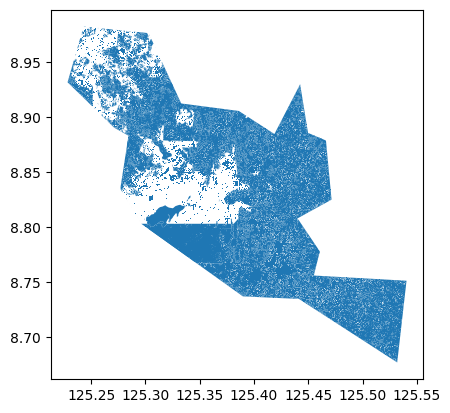

In [ ]:
cadt252_poly.plot()

In [ ]:
cadt252_multi = (
    cadt252[cadt252.geometry.type == "MultiPolygon"].copy().explode(index_parts=False)
)

In [ ]:
cadt252_multi.geometry.type.unique()

array(['Polygon'], dtype=object)

<Axes: >

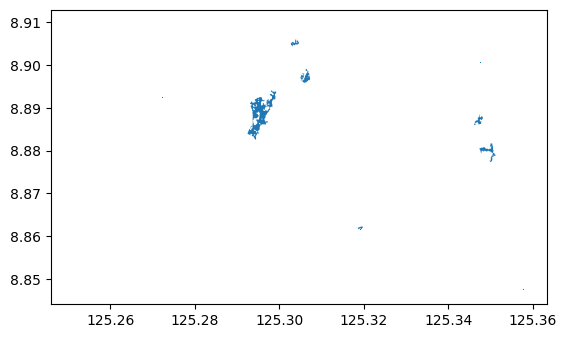

In [ ]:
cadt252_multi.plot()

In [ ]:
cadt252_collection = (
    cadt252[cadt252.geometry.type == "GeometryCollection"]
    .copy()
    .explode(index_parts=False)
)

In [ ]:
cadt252_collection.geometry.type.unique()

array(['MultiPolygon', 'LineString', 'Polygon', 'MultiLineString',
       'MultiPoint'], dtype=object)

In [ ]:
cadt252_collection_poly = cadt252_collection[
    cadt252_collection.geometry.type == "Polygon"
]

In [ ]:
cadt252_collection_multi = cadt252_collection[
    cadt252_collection.geometry.type == "MultiPolygon"
].explode(index_parts=False)

In [ ]:
cadt252_all = [
    cadt252_poly,
    cadt252_multi,
    cadt252_collection_poly,
    cadt252_collection_multi,
]

In [ ]:
cadt_252 = pd.concat(cadt252_all)

In [ ]:
cadt_252.geometry.type.unique()

array(['Polygon'], dtype=object)

In [ ]:
cadt_252.reset_index(drop=True, inplace=True)

In [ ]:
cadt_252.plot()

In [ ]:
cadt_252.geometry.type.unique()

array(['Polygon'], dtype=object)

In [ ]:
cadt_252 = cadt_252.explode(index_parts=False)

In [ ]:
# cadt252["geometry"] = cadt252.buffer(0)

In [ ]:
# cadt252 = GeometryValidation(cadt252).validate_all()


In [ ]:
cadt_252 = cadt_252[["CADT_No", "ELI_TYPE", "geometry"]].copy()

In [ ]:
cadt_252.rename(columns={"CADT_No": "CADT"}, inplace=True)

In [ ]:
activity_area_gdf = pd.concat(
    [activity_area_gdf[activity_area_gdf["CADT"] != 252], cadt_252]
)

In [ ]:
cadt_252.to_file(TMP_OUT_DIR / "cadt252_validated.gpkg")

# New

In [ ]:
# Standard Imports
import sys
import pandas as pd
import duckdb
import geopandas as gpd
from geowrangler.validation import GeometryValidation

# Google Cloud Imports

In [ ]:
# Util imports
sys.path.append("../../")  # include parent directory
from src.settings import GEOJSON_DATA_DIR, PARQUET_DATA_DIR, GPKG_DATA_DIR, TMP_OUT_DIR

In [ ]:
# Connect to the duckdb database
db = duckdb.connect(database=str(TMP_OUT_DIR / "activity_area.db"))

In [ ]:
db.execute("INSTALL spatial; LOAD spatial;")

In [ ]:
query = "SELECT name FROM sqlite_master WHERE type='table';"
db.execute(query).df()

In [ ]:
query = """
SELECT
    * 
FROM `phl-caraga-apd.00_transform.aud_risk_buffer`"""

# Read the BigQuery table into a dataframe
aud_risk_buffer = pandas_gbq.read_gbq(query, project_id="phl-caraga-apd")
# plot_info.to_csv(PLOT_INFO_CSV, index=False)

In [ ]:
aud_risk_buffer.info()

In [ ]:
# aud_risk_buffer['geometry'] = aud_risk_buffer['geometry'].apply(lambda x: loads(x))
# aud_risk_buffer = gpd.GeoDataFrame(aud_risk_buffer, geometry='geometry', crs="EPSG:4326")

In [ ]:
aud_risk_buffer = aud_risk_buffer.explode(index_parts=False)

In [ ]:
# aud_risk_buffer = GeometryValidation(aud_risk_buffer).validate_all()

In [ ]:
aud_risk_buffer["geometry"] = aud_risk_buffer["geometry"].apply(polygon_z_to_2d)

In [ ]:
aud_risk_buffer.head()

In [ ]:
aud_risk_buffer_df = aud_risk_buffer.copy()
aud_risk_buffer_df["geometry"] = aud_risk_buffer_df["geometry"].to_wkt()

In [ ]:
query = """
CREATE OR REPLACE TABLE aud_buffer AS
SELECT
    aud_clipping_layer,
    ST_GeomFromText(geometry) as geometry
FROM aud_risk_buffer_df
"""

In [ ]:
db.execute(query)

In [ ]:
query = """
CREATE OR REPLACE TABLE aud_adjusted AS
SELECT 
    activity_area.CADT,
    activity_area.ELI_TYPE,
    ST_AsText(ST_difference(activity_area.geometry, aud_buffer.geometry)) as geometry
FROM activity_area, aud_buffer
WHERE activity_area.ELI_TYPE = 'AUD'
"""

In [ ]:
db.execute(query)

In [ ]:
query = """ 
SELECT 
    SUM(ST_Area(geometry))/10000 as area_ha
FROM 
    activity_area
WHERE ELI_TYPE = 'AUD'
"""

In [ ]:
db.execute(query).df()

In [ ]:
query = """
SELECT 
    activity_area.CADT,
    activity_area.ELI_TYPE,
    lcc_cadt.lcc_type,
    ST_AsText(ST_Intersection(activity_area.geometry, lcc_cadt.geometry)) as geometry
FROM activity_area
JOIN lcc_cadt ON ST_Intersects(lcc_cadt.geometry, activity_area.geometry)
WHERE activity_area.ELI_TYPE = 'AUD'
"""

In [ ]:
aud_lcc = db.execute(query).df()

In [ ]:
aud_lcc["geometry"] = aud_lcc["geometry"].apply(lambda x: loads(x))
aud_lcc = gpd.GeoDataFrame(aud_lcc, geometry="geometry", crs="EPSG:4326")

In [ ]:
aud_lcc.to_file(TMP_OUT_DIR / "aud_lcc.gpkg")

In [ ]:
query = """
SELECT
    aud_clipping_layer,
    ST_AsText(geometry) as geometry
FROM aud_buffer
"""

In [ ]:
aud_buffer = db.execute(query).df()

In [ ]:
aud_buffer["geometry"] = aud_buffer["geometry"].apply(lambda x: loads(x))
aud_buffer = gpd.GeoDataFrame(aud_buffer, geometry="geometry", crs="EPSG:4326")

In [ ]:
aud_risk_buffer.to_file(TMP_OUT_DIR / "aud_buffer.gpkg")

In [ ]:
aud_risk_buffer = gpd.read_file(TMP_OUT_DIR / "aud_buffer.gpkg")

In [ ]:
aud_risk_buffer.geometry.type.unique()

array(['Polygon'], dtype=object)

In [ ]:
aud_risk_buffer = aud_risk_buffer.explode(index_parts=False)

In [ ]:
aud_risk_buffer = GeometryValidation(aud_risk_buffer).validate_all()

In [ ]:
lcc_cadt

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
activity_area_gdf

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
intersection = gpd.overlay(activity_area_gdf, lcc_cadt, how="intersection")

In [ ]:
intersection.columns

Index(['CADT', 'ELI_TYPE', 'is_not_null_1', 'is_not_self_intersecting_1',
       'is_oriented_properly_1', 'is_within_crs_bounds_1',
       'area_is_not_zero_1', 'DN', 'is_not_null_2',
       'is_not_self_intersecting_2', 'is_oriented_properly_2',
       'is_within_crs_bounds_2', 'area_is_not_zero_2', 'geometry'],
      dtype='object')

In [ ]:
intersection_subset = intersection[["CADT", "ELI_TYPE", "DN", "geometry"]].copy()

In [ ]:
intersection_subset["area_ha"] = intersection_subset.to_crs("EPSG:3123").area / 10_000

In [ ]:
intersection_subset.loc[intersection_subset.DN.isin([1, 4])].groupby(
    ["ELI_TYPE", "DN"]
)["area_ha"].sum().reset_index()

,ELI_TYPE,DN,area_ha
0,APD,1,77484.270555
1,APD,4,8352.383667
2,ARR,1,20376.120785
3,ARR,4,6117.535770
4,AUD,1,84435.550595
5,AUD,4,6498.570408
6,NOT ELIGIBLE,1,65022.450176
7,NOT ELIGIBLE,4,9711.503304


In [ ]:
8352.38 + 77484.27

85836.65000000001

In [ ]:
intersection_subset.to_file(TMP_OUT_DIR / "lcc_cadt.gpkg")

In [ ]:
aud_subset = intersection_subset[intersection_subset["ELI_TYPE"] == "AUD"].copy()

In [ ]:
aud_buffered = gpd.overlay(
    aud_subset, aud_risk_buffer, how="difference", keep_geom_type=False, make_valid=True
)

In [ ]:
aud_buffered.plot()

In [ ]:
aud_buffered["area_ha"] = aud_buffered.to_crs("EPSG:3123").area / 10_000

In [ ]:
aud_buffered.loc[aud_buffered.DN.isin([1, 4])].groupby(["ELI_TYPE", "DN"])[
    "area_ha"
].sum().reset_index()

,ELI_TYPE,DN,area_ha
0,AUD,1,32114.017886
1,AUD,4,1980.082207


In [ ]:
1980.08 + 32114.01

34094.09

In [ ]:
activity_area_gdf.loc[activity_area_gdf.ELI_TYPE == "AUD"].to_crs(
    "EPSG:3123"
).area.sum() / 10_000

np.float64(94891.67981865711)

In [ ]:
lcc_252 = gpd.read_file(TMP_OUT_DIR / "lcc_252.gpkg")

In [ ]:
lcc_252_forest = lcc_252.loc[lcc_252["DN"].isin([1, 4])].copy()

In [ ]:
cadt252_lcc = gpd.overlay(cadt_252, lcc_252_forest, how="intersection", make_valid=True)

In [ ]:
cadt252_lcc["area_ha"] = cadt252_lcc.to_crs("EPSG:3123").area / 10_000

In [ ]:
cadt252_lcc.loc[cadt252_lcc.DN.isin([1, 4])].groupby(["ELI_TYPE", "DN"])[
    "area_ha"
].sum().reset_index()

,ELI_TYPE,DN,area_ha
0,APD,1,4968.133207
1,APD,4,1643.502888
2,ARR,1,380.947218
3,ARR,4,415.760852
4,AUD,1,6307.349049
5,AUD,4,1300.052391
6,NOT ELIGIBLE,1,3475.232530
7,NOT ELIGIBLE,4,1423.331510


In [ ]:
cadt_252["area_ha"] = cadt_252.to_crs("EPSG:3123").area / 10_000

In [ ]:
8325.38 + 4968.13 + 79127.77

92421.28

In [ ]:
cadt_252.groupby("ELI_TYPE")["area_ha"].sum()

ELI_TYPE
APD              8224.238482
ARR              8587.390964
AUD              7812.618926
NOT ELIGIBLE    22250.186604
Name: area_ha, dtype: float64

In [ ]:
activity_area_gdf["area_ha"] = activity_area_gdf.to_crs("EPSG:3123").area / 10_000

In [ ]:
activity_area_gdf.groupby("ELI_TYPE")["area_ha"].sum()

ELI_TYPE
APD             100603.234714
ARR              50878.591418
AUD             102704.298745
NOT ELIGIBLE    145767.442535
Name: area_ha, dtype: float64

In [ ]:
aud_subset_252 = cadt252_lcc[cadt252_lcc["ELI_TYPE"] == "AUD"].copy()

In [ ]:
aud_subset_252.plot()

In [ ]:
aud_risk_buffer.plot()

In [ ]:
aud_buffered_252 = gpd.overlay(
    aud_subset_252,
    aud_risk_buffer,
    how="difference",
    keep_geom_type=False,
    make_valid=True,
)

In [ ]:
aud_buffered_252.plot()

In [ ]:
aud_buffered_252

,CADT,ELI_TYPE,DN,geometry,area_ha
0,252.0,AUD,1,"POLYGON ((125.26953 8.89251, 125.26950 8.89251...",9.867983e-03
1,252.0,AUD,4,"MULTIPOLYGON (((125.26944 8.89229, 125.26944 8...",1.438505e-01
2,252.0,AUD,4,"MULTIPOLYGON (((125.26827 8.89341, 125.26827 8...",2.960467e-02
3,252.0,AUD,1,"MULTIPOLYGON (((125.26818 8.89350, 125.26818 8...",5.515033e-03
4,252.0,AUD,4,"POLYGON ((125.26818 8.89359, 125.26818 8.89359...",7.075380e-07
...,...,...,...,...,...
1177,252.0,AUD,1,"POLYGON ((125.37211 8.85757, 125.37203 8.85757...",4.936266e-02
1178,252.0,AUD,1,"MULTIPOLYGON (((125.36825 8.85541, 125.36825 8...",1.756797e-02
1179,252.0,AUD,4,"POLYGON ((125.29935 8.84176, 125.29935 8.84167...",2.218774e-06
1180,252.0,AUD,1,"MULTIPOLYGON (((125.37463 8.85640, 125.37463 8...",7.080696e-07


In [ ]:
aud_risk_buffer

,aud_clipping_layer,geometry,is_not_null,is_not_self_intersecting,is_oriented_properly,is_within_crs_bounds,area_is_not_zero
0,aud_risk_CADT_No_002,"POLYGON ((125.94515 9.08906, 125.94515 9.08897...",True,True,True,True,True
1,aud_risk_CADT_No_002,"POLYGON ((125.98800 9.10955, 125.98809 9.10955...",True,True,True,True,True
2,aud_risk_CADT_No_002,"POLYGON ((126.00794 9.05125, 126.00794 9.05116...",True,True,True,True,True
3,aud_risk_CADT_No_002,"POLYGON ((126.03319 9.07343, 126.03310 9.07343...",True,True,True,True,True
4,aud_risk_CADT_No_002,"POLYGON ((125.99411 9.07945, 125.99411 9.07954...",True,True,True,True,True
...,...,...,...,...,...,...,...
113312,aud_risk_CADT_No_256,"POLYGON ((125.63694 9.05116, 125.63685 9.05116...",True,True,True,True,True
113313,aud_risk_CADT_No_256,"POLYGON ((125.62292 9.07271, 125.62292 9.07263...",True,True,True,True,True
113314,aud_risk_CADT_No_256,"POLYGON ((125.64260 9.05753, 125.64260 9.05762...",True,True,True,True,True
113315,aud_risk_CADT_No_256,"POLYGON ((125.63631 9.04442, 125.63631 9.04433...",True,True,True,True,True


In [ ]:
aud_buffered_252["area_ha"] = aud_buffered_252.to_crs("EPSG:3123").area / 10_000

In [ ]:
aud_buffered_252.loc[aud_buffered_252.DN.isin([1, 4])].groupby(["ELI_TYPE", "DN"])[
    "area_ha"
].sum().reset_index()

,ELI_TYPE,DN,area_ha
0,AUD,1,2.168693e-08
1,AUD,4,3.794391e-08
